In [193]:
import numpy             as np
import matplotlib.pyplot as plt
import yt


from scipy.spatial import cKDTree, Delaunay
from numba         import njit, jit
from yt.funcs      import mylog
mylog.setLevel(40) # This sets the log level to "ERROR"


import magritte.mesher as mesher

In [2]:
ndim    = 3
npoints = 250
nnbs    = 50

In [3]:
r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]

scale_max = 0.11 * r_out
scale_min = 0.11 * r_in
scale_cte = 0.11 * r_in
scale_fun = f'{scale_cte / r_in**2} * (x*x + y*y + z*z)'

In [4]:
meshName = f'/home/frederik/Desktop/test.vtk'

mesher.create_mesh_from_function(
    meshName       = meshName,
    boundary       = mesher.boundary_sphere_in_sphere(
                         radius_in  = r_in,
                         radius_out = r_out),
    scale_min      = scale_min,
    scale_max      = scale_max,
    scale_function = scale_fun )

mesh = mesher.Mesh(meshName)

Info    : Running 'gmsh /home/frederik/Desktop/test.geo -3 -saveall -o /home/frederik/Desktop/test.vtk' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Tue Mar  2 11:50:32 2021
Info    : Reading '/home/frederik/Desktop/test.geo'...
Info    : Done reading '/home/frederik/Desktop/test.geo'
Info    : Meshing 1D...
Info    : Meshing curve 101 (Circle)
Info    : Meshing curve 102 (Circle)
Info    : Meshing curve 103 (Circle)
Info    : Meshing curve 104 (Circle)
Info    : Meshing curve 105 (Circle)
Info    : Meshing curve 106 (Circle)
Info    : Meshing curve 107 (Circle)
Info    : Meshing curve 108 (Circle)
Info    : Meshing curve 109 (Circle)
Info    : Meshing curve 110 (Circle)
Info    : Meshing curve 111 (Circle)
Info    : Meshing curve 112 (Circle)
Info    : Meshing curve 201 (Circle)
Info    : Meshing curve 202 (Circle)
Info    : Meshing curve 203 (Circle)
Info    : Meshing curve 204 (Circle)
Info    : Meshing curve 205 (Circle)
Info    : Meshing curve 206 (Circle)
Info    : Me

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


6


In [5]:
npoints = len(mesh.points)
nbs     = [n for sublist in mesh.neighbors for n in sublist]
n_nbs   = [len(sublist) for sublist in mesh.neighbors]

In [7]:
xs = mesh.points
# xs         = np.random.rand(npoints, ndim)
# xs         = np.array([np.logspace(-2, 1, npoints)]).T
# xs         = np.array([np.linspace(0, 1, npoints)]).T

rs = np.linalg.norm(xs, axis=1)

KDTree     = cKDTree(xs)
dists, ids = KDTree.query(xs, nnbs+1)

delaunay   = Delaunay(xs)
ptrs, inds = delaunay.vertex_neighbor_vertices

# Initialize hs and grad_hs
hs        = np.mean(dists[:,1:], axis=1)
grad_hs   = np.zeros((npoints, ndim))

In [8]:
def get_hs_stats():
    """
    Returns for each point the distance to its farthest neighbour,
    and the average distance to all its neighbours.
    """
    # Initialize a new array
    hs_min  = np.zeros(npoints)
    hs_mean = np.zeros(npoints)
    # Loop over all points
    for i in range(npoints):
#         nbs = inds[ptrs[i]:ptrs[i+1]]
        nbs  = mesh.neighbors[i]
        dist = np.linalg.norm(xs[i] - xs[nbs], axis=1)
        hs_min [i] = np.max (dist)
        hs_mean[i] = np.mean(dist)
    return hs_min, hs_mean

In [29]:
hs_min, hs_mean = get_hs_stats()

In [37]:
def smooth_hs(hs):
    for i, nbs in enumerate(mesh.neighbors):
        hs[i] = (hs[i] + np.sum(hs[nbs])) / (len(nbs) + 1)
    return hs

In [20]:
def max_local_change(hs):
    mlc = np.zeros(npoints)
    for i, nbs in enumerate(mesh.neighbors):
        mlc[i] = np.max(hs[i] - hs[nbs]) / hs[i]
    return mlc

In [24]:
def plot_slice(data):

    ds = yt.load_unstructured_mesh(
             connectivity = np.array(mesh.tetras, dtype=np.int64  ),
             coordinates  = np.array(mesh.points, dtype=np.float64),
             node_data    = {('connect1', 'data'): data[mesh.tetras]})

    sl = yt.SlicePlot(ds, 'x', 'data')
    return sl

In [62]:
hs = hs_min

0.6249192135475561


/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



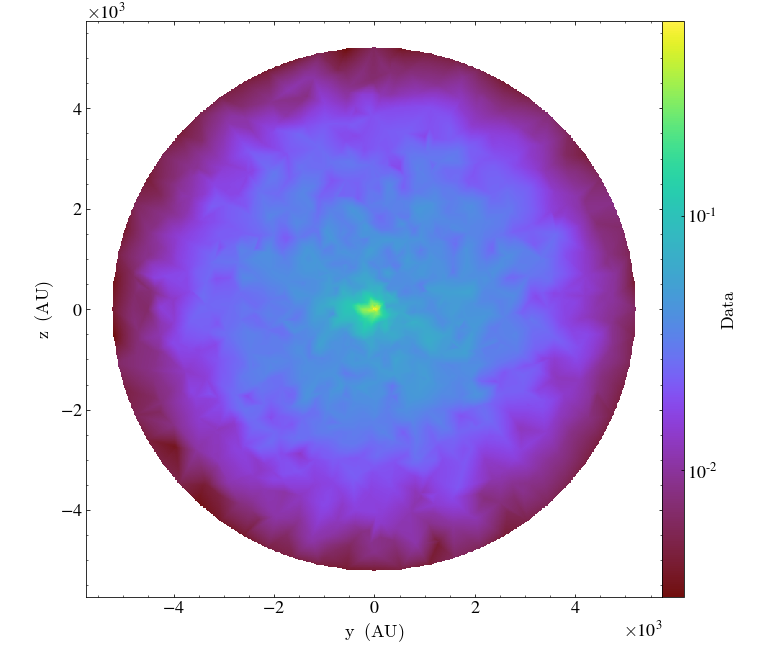

In [184]:
mlc = max_local_change(hs)

print(np.max(mlc))
plot_slice(mlc)

In [185]:
for _ in range(10):
    hs = smooth_hs(hs)

0.6172180843275482
0.05377389839456887


/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



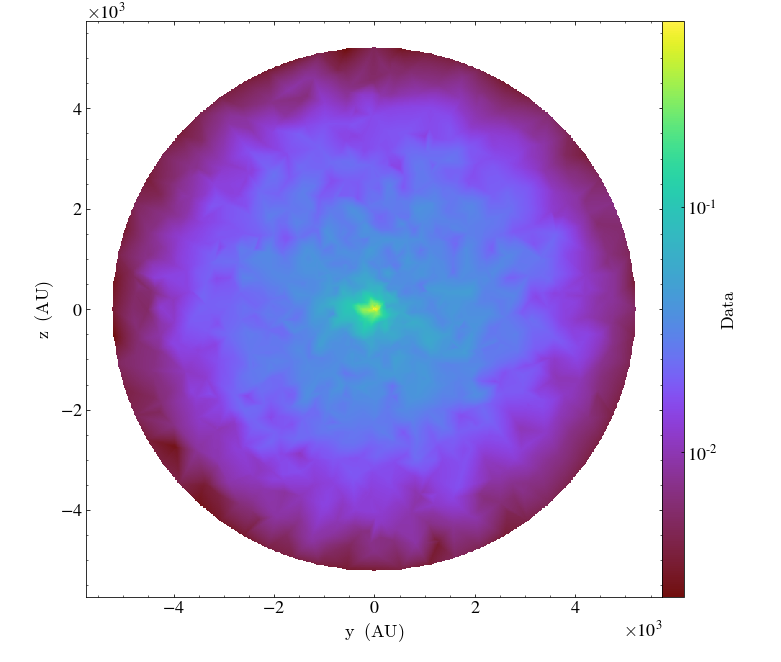

In [186]:
mlc = max_local_change(hs)

print(np.max(mlc))
print(np.mean(mlc))
plot_slice(mlc)

In [187]:
hs

array([7.16213734e+13, 6.30259196e+13, 6.21711850e+13, ...,
       9.08600153e+15, 9.25410062e+15, 9.36582505e+15])

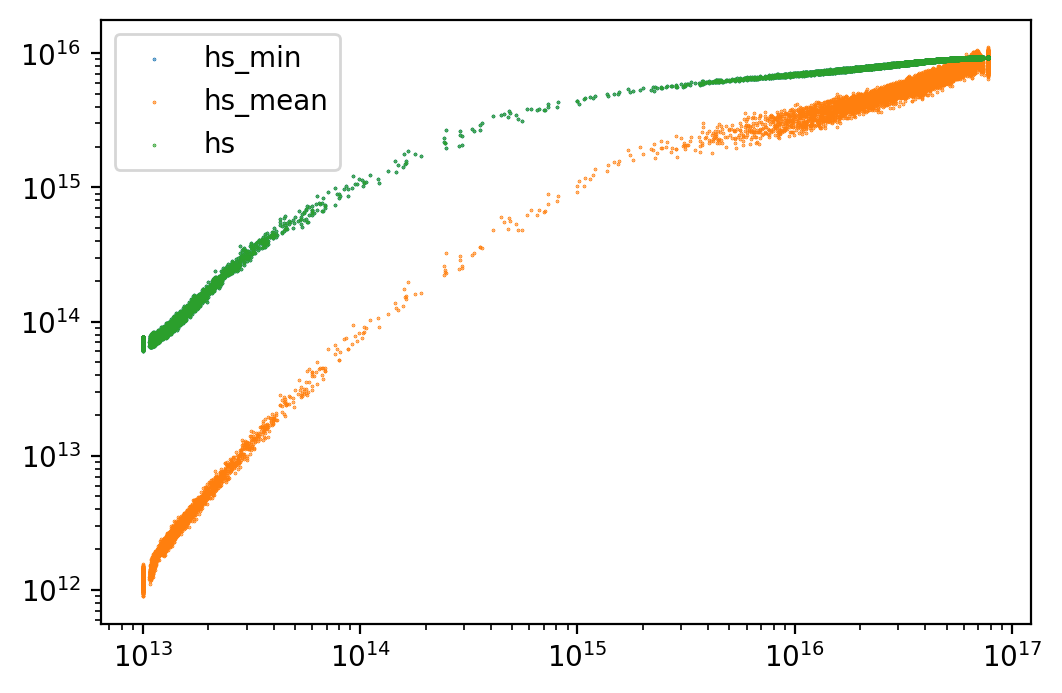

In [188]:
plt.figure(dpi=200)
plt.scatter(rs, hs_min,  s=0.1, label='hs_min')
plt.scatter(rs, hs_mean, s=0.1, label='hs_mean')
plt.scatter(rs, hs,      s=0.1, label='hs')
plt.xscale('log')
plt.yscale('log')
plt.legend()

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



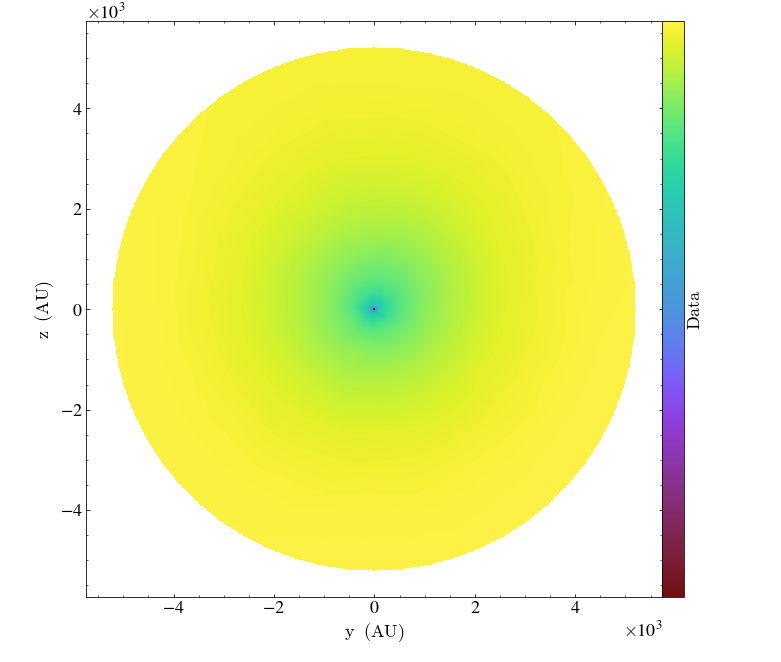

In [189]:
plot_slice(hs)

In [ ]:
hs = smooth_hs(hs)

In [93]:
hs_min[nbs]

array([1.96359753e+12, 1.50681282e+12, 2.08225658e+12, 1.76699277e+12,
       1.95723605e+12, 1.29283912e+12, 1.50681282e+12, 1.76699277e+12,
       2.16357263e+12, 1.95829250e+12, 1.36154962e+12, 2.32720884e+12,
       1.50681282e+12, 1.50681282e+12, 1.29843949e+12, 1.95829250e+12,
       1.76699277e+12, 1.76699277e+12, 1.29843949e+12, 1.50462597e+12,
       2.32720884e+12, 2.16357263e+12])

In [84]:
hs_min, hs_mean = get_hs_stats()

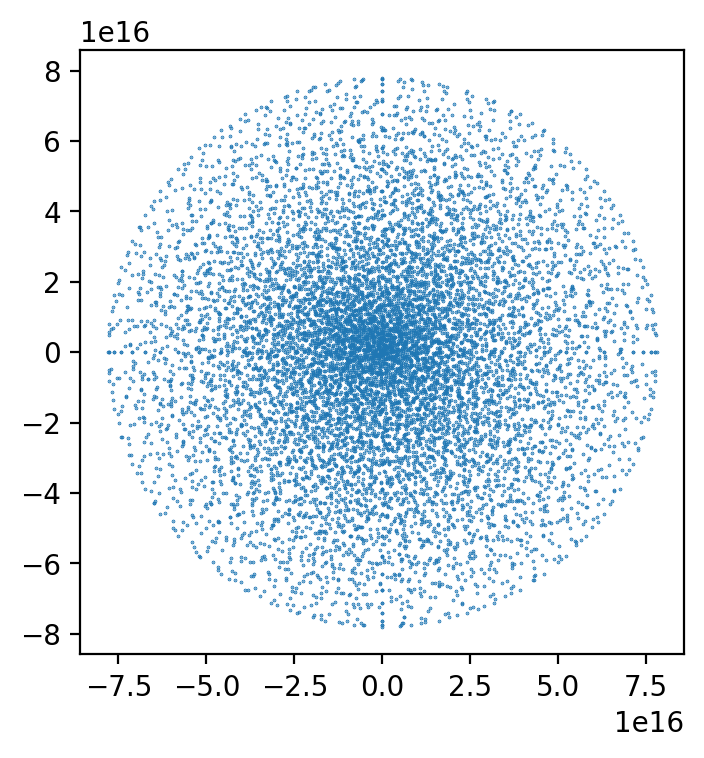

In [76]:
plt.figure(dpi=200)
plt.axes().set_aspect('equal')
plt.scatter(xs[:,0], xs[:,1], s=0.1)

In [205]:
import jax
import jax.numpy as jnp

# @jit
def RBF_Lucy(r):
    """
    Lucy's smoothing kernel (Lucy 1977).
    """
    # Ensure to take the absolute value
    rr = jnp.abs(r)
    # Compute Lucy's kernel
    if (rr < 1.0):
        return (1.0 + 3.0*rr) * (1 - rr)**3
    else:
        return 0.0

Consider a kernel, $k$, of the form
\begin{equation}
k(x,y) \ = \ K \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}
Then one can compute
\begin{equation}
\partial_{y}k(x,y) \ = \ -\frac{1}{h(x) \, h(y)} \left(2\left(x-y\right) + \left(x-y\right)^{2} \partial_{y} \log h(y)\right) K' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}

In [206]:
# Define kernel
KK = RBF_Lucy

# Define gradient with JAX (autograd)
grad_KK  = jax.grad(KK)
grad2_KK = jax.grad(jax.grad(KK))

In [207]:
%timeit KK(0.5)

1.08 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [208]:
%timeit grad_KK(0.5) 

5.17 ms ± 56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [209]:
%timeit grad2_KK(0.5) 

12.5 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


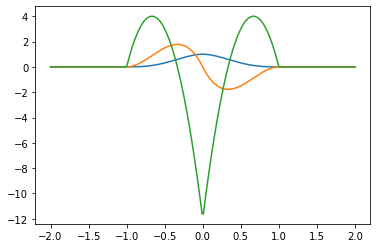

In [210]:
x = np.linspace(-2, 2, 250)

Ks   = [      KK(r) for r in x]
gKs  = [ grad_KK(r) for r in x]
g2Ks = [grad2_KK(r) for r in x]

plt.plot(x,   Ks)
plt.plot(x,  gKs)
plt.plot(x, g2Ks)

In [151]:
@njit
def kernel(i, j):
    """
    k(x,y) = K(|x-y|^2 / h(x)h(y))
    """
    d = xs[i] - xs[j]
    r = np.dot(d,d) / (hs[i] * hs[j])
    return KK(r)

In [152]:
@njit
def dj_kernel(i, j):
    """
    ∂k(x,y)/∂y
    """
    d = xs[i] - xs[j]
    a = 1.0 / (hs[i] * hs[j])
    r = np.dot(d,d) * a
    return (-2.0*d*a - r*dlog_hs[j]) * grad_KK(r)

@njit
def di_kernel(i, j):
    """
    ∂k(x,y)/∂x
    """
    d = xs[i] - xs[j]
    a = 1.0 / (hs[i] * hs[j])
    r = np.dot(d,d) * a
    return (+2.0*d*a - r*dlog_hs[j]) * grad_KK(r)

@njit
def dij_kernel(i, j):
    """
    ∂∂k(x,y)/∂x∂y
    """
    d = xs[i] - xs[j]
    a = 1.0 / (hs[i] * hs[j])
    r = np.dot(d,d) * a
    term1 = -2.0*a*(1.0 + d*(dlog_hs[j] - dlog_hs[i])) - r*dlog_hs[i]*dlog_hs[j] 
    term2 = (+2.0*d*a - r*dlog_hs[j]) * (-2.0*d*a - r*dlog_hs[j])
    return term1*grad_KK(r) + term2*grad2_KK(r)

In [ ]:
# @njit
def get_covariance():
    # initialize
    data = np.zeros(datsize_cov, dtype=np.float64)
    id_i = np.zeros(datsize_cov, dtype=np.int64)
    id_j = np.zeros(datsize_cov, dtype=np.int64)
    # set index
    index = 0
    # For all boundary points
    for b1 in range(nboundary):
        p1 = boundary2point[b1]

        for f1 in range(nfreqs):
            for r1 in range(nrays):
                
                # For all boundary points (close to the considered boundary point p1)
                for i2 in range(min([len(ind_bdy[b1]), nboundary])):
                    b2 = ind_bdy[b1][i2]
                    p2 = boundary2point[b2]
                    
                    for f2 in range(nfreqs):
                        for r2 in range(nrays):
            
                            kk = k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*b1) 
                            j2 = r2 + nrays*(f2 + nfreqs*b2)
                
                            data[index] = kk
                            id_i[index] = j1 
                            id_j[index] = j2
                            index += 1
                            
#                             print ('kk  ', p1, r1, ';', p2, r2, ' ', kk)
 
                # For all (general) points (close to the considered boundary point p1)
                for i2 in range(min([len(ind_all[p1]), npoints])):
                    p2 = ind_all[p1][i2]
                    
                    for f2 in range(nfreqs):
                        for r2 in range(nrays):
                    
                            Lk = L_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs* b1             ) 
                            j2 = r2 + nrays*(f2 + nfreqs*(p2 + nboundary))

                            data[index] = Lk
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1
                            
                            data[index] = Lk
                            id_i[index] = j2
                            id_j[index] = j1 
                            index += 1
                        
#                             print ('Lk', Lk, p1, r1, p2, r2)
                            
    # For all (general) points
    for p1 in range(npoints):
        i1 = p1 + nboundary
        
        for f1 in range(nfreqs):
            for r1 in range(nrays):
            
                # For all (general) points (close to the considered general point p1)
                for i2 in range(min([len(ind_all[p1]), npoints])):
                    p2 = ind_all[p1][i2]
                    
                    for f2 in range(nfreqs):
                        for r2 in range(nrays):
                            
                            L2 = L2_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs* i1             ) 
                            j2 = r2 + nrays*(f2 + nfreqs*(p2 + nboundary))
                            
                            data[index] = L2
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1
                            
#                             print ('L2  ', p1, r1, ';', p2, r2, ' ', L2)
                            
    return (data, (id_i, id_j))
 

# @njit
def get_condition():
    
    # initialize
    condition = np.zeros(matsize)
    # compute

    # For all boundary points
    for i1 in range(nboundary):
        p1 = boundary2point[i1]
        
        for f1 in range(nfreqs):
            for r1 in range(nrays):    
            
#                 if np.dot([1,0,0], Rs[r1]) > 0:
#                 if (i1 == 0):
            
                j1 = r1 + nrays*(f1 + nfreqs*i1)
                
#                 condition[j1] = boundary_condition[i1,f1]
                condition[j1] = 0.0

    # For all (general) points
    for p1 in range(npoints):
        i1 = p1 + nboundary
        
        for f1 in range(nfreqs):
            for r1 in range(nrays):

                j1 = r1 + nrays*(f1 + nfreqs* i1)
                
#                 condition[j1] = eta[p1,f1] / chi[p1,f1]
                condition[j1] = 1.0

    return condition

In [63]:
@njit
def max_relative_difference(a, b):
    return 2.0*np.max(np.abs((a - b)/(a + b)))

In [64]:
@njit
def recompute_hs(hs):
    # Initialize a new array
    hs_new = np.zeros(npoints)
    # Loop over all points
    for i in range(npoints):
        norm = 0.0
        for (j, dist) in zip(ids[i][1:], dists[i][1:]):
            kern       = kernel(i, j, 10*hs)
            norm      += kern
            hs_new[i] += kern * dist
        # Normalize  
        hs_new[i] /= norm    
    print('max relative change =', max_relative_difference(hs, hs_new))
    # Return new hs
    return hs_new

In [65]:
for i in range(20):
    hs = recompute_hs(hs)
hs

max relative change = 0.13530932989278271
max relative change = 0.00486506576973013
max relative change = 6.623049948100747e-05
max relative change = 6.518146256602535e-07
max relative change = 4.617519408534958e-09
max relative change = 2.7499793504977122e-11
max relative change = 1.519444513428365e-13
max relative change = 1.652721018248686e-15
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16
max relative change = 6.950570920080165e-16


array([2.04375740e+12, 2.00774032e+12, 2.12787171e+12, ...,
       1.04643683e+16, 1.33944901e+16, 1.32867353e+16])

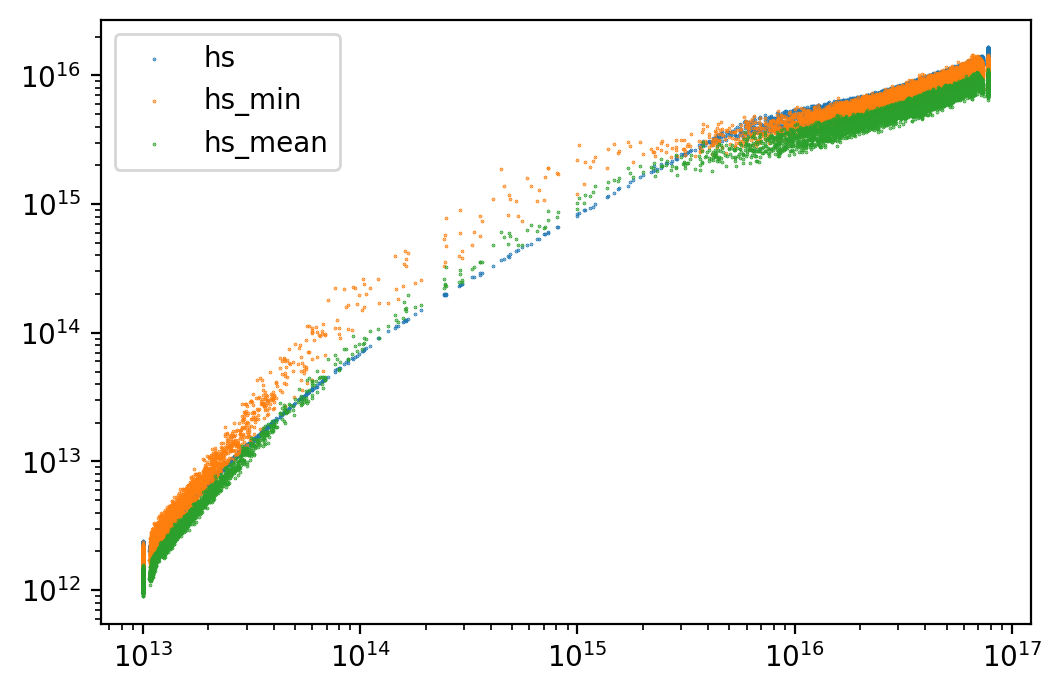

In [85]:
plt.figure(dpi=200)
plt.scatter(rs, hs,      s=0.1, label='hs')
plt.scatter(rs, hs_min,  s=0.1, label='hs_min')
plt.scatter(rs, hs_mean, s=0.1, label='hs_mean')
plt.xscale('log')
plt.yscale('log')
plt.legend()

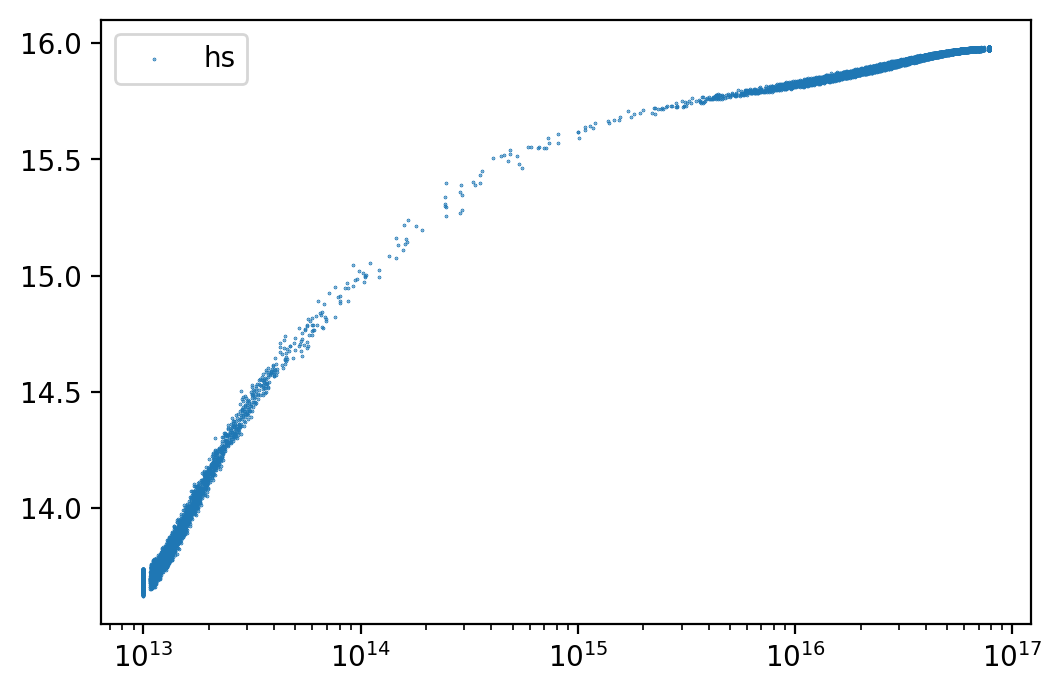

In [173]:
plt.figure(dpi=200)
plt.scatter(rs, np.log10(hs), s=0.1, label='hs')
plt.xscale('log')
# plt.yscale('log')
plt.legend()

Computing the gradient based on nearest neighbor information based on Meyer, Eriksson, and Maggio (2001).
For a point at position $\textbf{x}_{i}$, and nearest neighbors $\textbf{x}_{j}$, we can observe that
\begin{equation}
f_{j} - f_{i} \ = \ \left(\textbf{x}_{j} - \textbf{x}_{i} \right) \cdot \nabla f_{i}
\end{equation}

\begin{equation}
\Delta f \ = \ \Delta \textbf{x} \cdot \nabla f
\end{equation}

\begin{equation}
\nabla f \ = \
\left( \Delta \textbf{x} ^{\text{T}} \Delta \textbf{x} \right)^{-1} \ \Delta \textbf{x}^{\text{T}} \Delta f
\end{equation}

In [174]:
def get_grad_hs(hs):
    # Initialize a new array
    grad_hs = np.zeros((npoints, ndim))
    # Loop over all points
    for i in range(npoints):
#         nbs = ids[i][1:]
#         nbs = inds[ptrs[i]:ptrs[i+1]]
        nbs = mesh.neighbors[i]
        dx  = xs[i] - xs[nbs]
        dh  = hs[i] - hs[nbs]
        grad_hs[i] = np.matmul(np.linalg.inv(np.matmul(dx.T, dx)), np.matmul(dx.T, dh))
    # return grad
    return grad_hs

In [175]:
grad_hs      = get_grad_hs(hs)
grad_hs_norm = np.linalg.norm(grad_hs, axis=1)

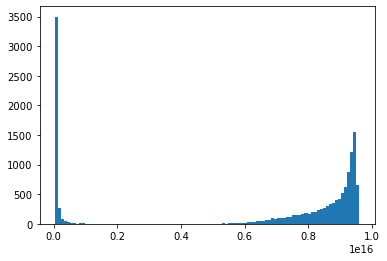

In [176]:
plt.hist(hs, bins=100)
plt.show()

The following is a "smooth" way to define the local element size distribution
\begin{equation}
    h^2(x_i) \ = \
    \frac{\sum_{j} ( x_i - x_j )^2 \ k(x_i, x_j) }
         {\sum_{j}                   k(x_i, x_j) }.
\end{equation}
However, it is recusrively defined, since $k$ depends on $h$, but can be (recursively) computed.
\begin{equation}
    h^{2}(x) \ = \
    \frac{\sum_{j} ( x - x_j )^2  k(x, x_j) }
         {\sum_{j}                k(x, x_j) }.
\end{equation}

The kernel expasion of the local element size distribution is given by
\begin{equation}
    h^{2}(x) \ = \ \sum_{j} w_j \ k(x, x_j),
\end{equation}
and can be used to interpolate.